In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
# !rm -r /content/runs

In [ ]:
# !unzip '/content/drive/MyDrive/vehicle_detection_yolov5.zip' -d '/content/drive/MyDrive'

In [ ]:
!pip install ultralytics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.0/722.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [8]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image
from ultralytics import YOLO
from IPython.display import Video

import torch

In [9]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#eae8fa'}, style='darkgrid')

In [10]:
model = YOLO('yolov5l.yaml')

In [11]:
# Define the dataset_path
dataset_path = '/content/drive/MyDrive/vehicle_detection_yolov5/'

# Set the path to the YAML file
yaml_file_path = '/content/drive/MyDrive/vehicle_detection_yolov5/data.yaml'


# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- bus
- car
- motorcycle
- truck
nc: 4
train: ../train/images
val: ../valid/images



In [12]:
# Set paths for training and validation image sets
train_images_path = os.path.join('/content/drive/MyDrive/vehicle_detection_yolov5/train', 'images')
test_images_path = os.path.join('/content/drive/MyDrive/vehicle_detection_yolov5/test', 'images')
valid_images_path = os.path.join('/content/drive/MyDrive/vehicle_detection_yolov5/valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'):
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 2010
Number of validation images: 80
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


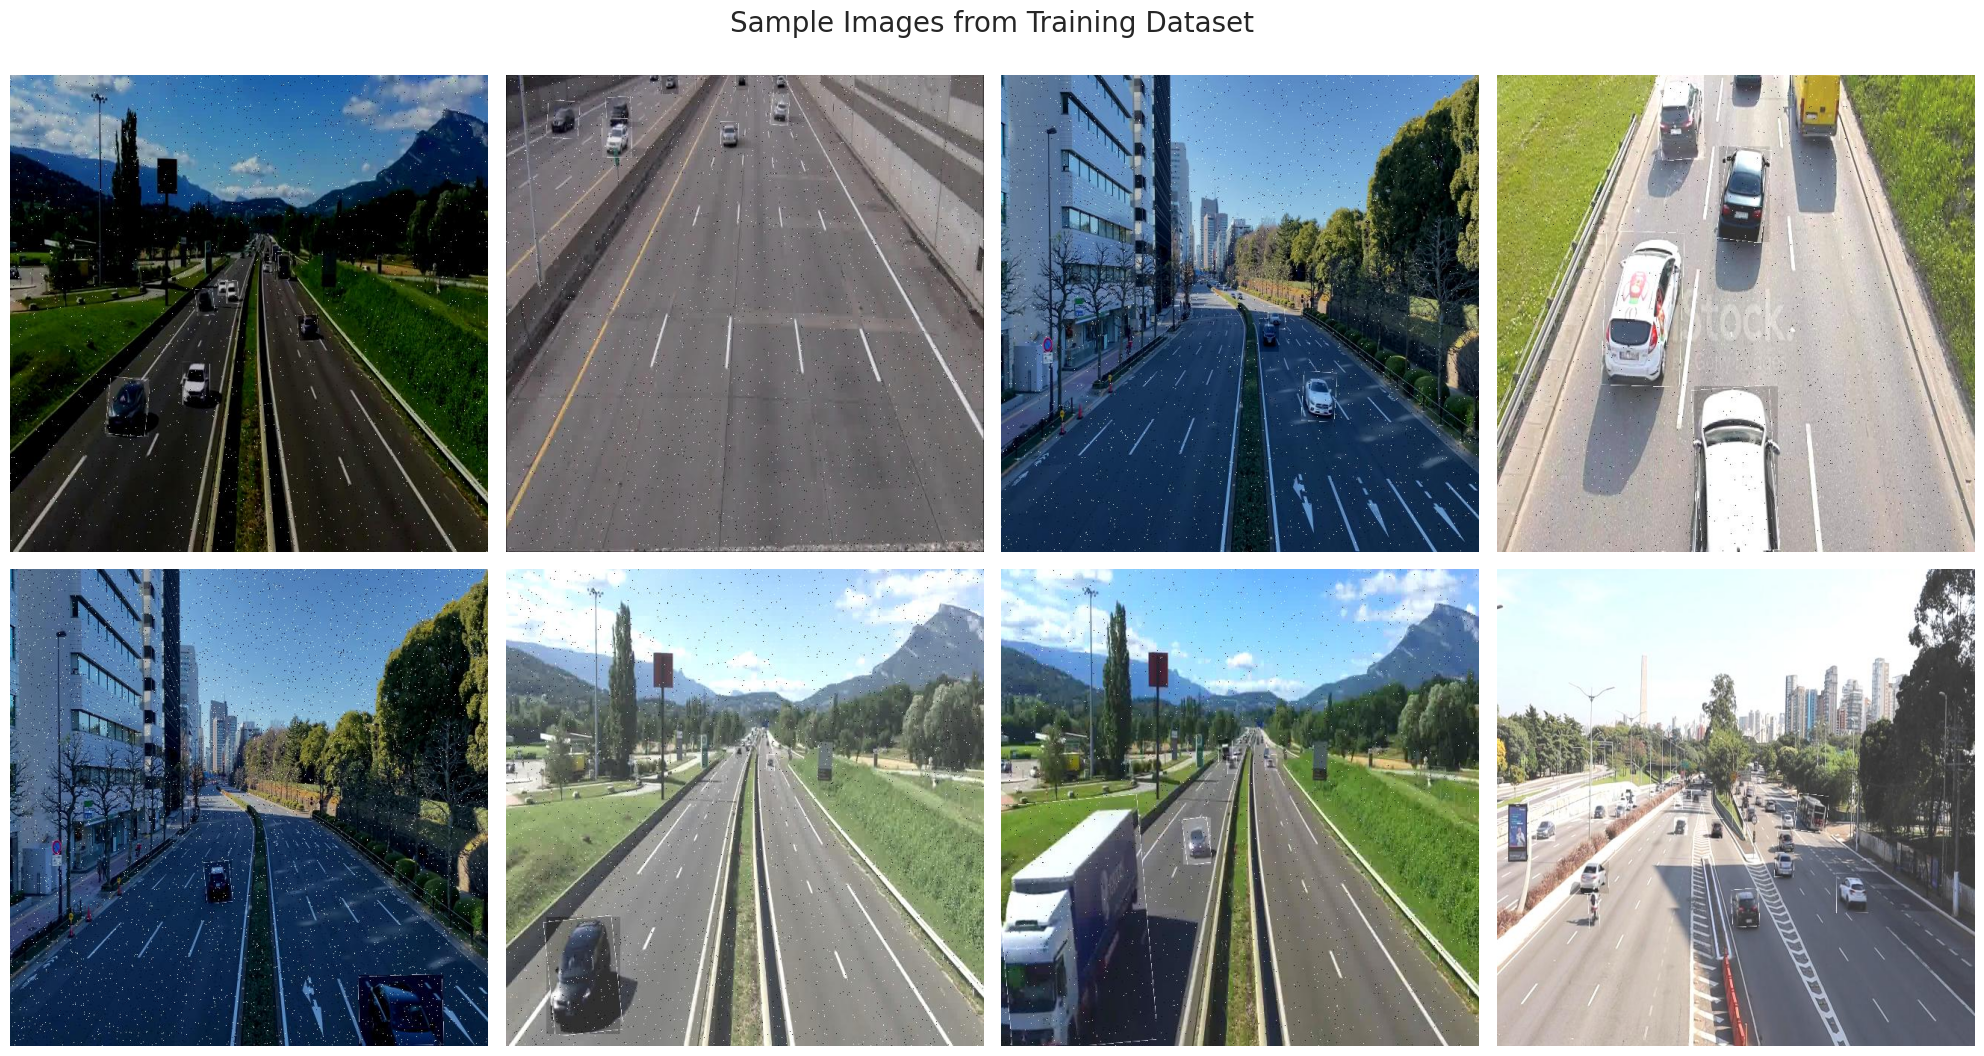

In [13]:
# List all jpg images in the directory
image_files = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]

# Select 8 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 8)]

# Create a 2x4 subplot
fig, axes = plt.subplots(2, 4, figsize=(20, 11))

# Display each of the selected images
for ax, img_file in zip(axes.ravel(), selected_images):
    img_path = os.path.join(train_images_path, img_file)
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle('Sample Images from Training Dataset', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
#NB == n'entrainer que sur 40 epochs, ça suffit vu les courbes de loss
# Train the model on our custom dataset
results = model.train(
    data='/content/drive/MyDrive/vehicle_detection_yolov5/data.yaml',     # Path to the dataset configuration file
    epochs=100,              # Number of epochs to train for
    imgsz=640,               # Size of input images as integer
    device=0,                # Device to run on, i.e. cuda device=0
    patience=25,             # Epochs to wait for no observable improvement for early stopping of training
    batch=16,                # Number of images per batch
    optimizer='auto',        # Optimizer to use, choices=[SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto]
    lr0=0.001,              # Initial learning rate
    lrf=0.1,                 # Final learning rate (lr0 * lrf)
    dropout=0.1,             # Use dropout regularization
    seed=42                  # Random seed for reproducibility
)

Ultralytics YOLOv8.1.30 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov5l.yaml, data=/content/drive/MyDrive/vehicle_detection_yolov5/data.yaml, epochs=100, time=None, patience=25, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning /content/drive/MyDrive/vehicle_detection_yolov5/train/labels... 2010 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2010/2010 [00:17<00:00, 117.94it/s]


train: New cache created: /content/drive/MyDrive/vehicle_detection_yolov5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/vehicle_detection_yolov5/valid/labels... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:01<00:00, 61.23it/s]

val: New cache created: /content/drive/MyDrive/vehicle_detection_yolov5/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.1G      3.567      3.552      3.598         82        640: 100%|██████████| 126/126 [01:35<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all         80        822      0.564     0.0524     0.0384      0.013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      11.2G      2.183      1.969      2.149        179        640: 100%|██████████| 126/126 [01:30<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         80        822      0.347      0.114     0.0911     0.0351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      11.5G      1.489      1.384      1.507        154        640: 100%|██████████| 126/126 [01:31<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         80        822      0.454       0.17      0.138     0.0513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      11.5G      1.223      1.172      1.258         90        640: 100%|██████████| 126/126 [01:33<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         80        822      0.908      0.134      0.165     0.0587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      11.8G      1.101      1.041      1.166        127        640: 100%|██████████| 126/126 [01:32<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         80        822      0.264      0.182      0.163     0.0563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.8G      1.006     0.9291      1.119        213        640: 100%|██████████| 126/126 [01:33<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         80        822      0.503      0.179       0.17     0.0574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      11.9G     0.9724     0.8919      1.095        100        640: 100%|██████████| 126/126 [01:33<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         80        822      0.399      0.358      0.356      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      11.9G     0.9294     0.8415      1.063         70        640: 100%|██████████| 126/126 [01:33<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         80        822      0.288      0.298      0.236     0.0917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      11.5G     0.9175     0.8072      1.047        146        640: 100%|██████████| 126/126 [01:34<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         80        822      0.559      0.319      0.359      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100        12G     0.8623     0.7603      1.029        108        640: 100%|██████████| 126/126 [01:35<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         80        822      0.449      0.312      0.297      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100        12G     0.8289     0.7161       1.01        123        640: 100%|██████████| 126/126 [01:36<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         80        822      0.432      0.274      0.274     0.0895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100        12G     0.8295     0.7168      1.005        134        640: 100%|██████████| 126/126 [01:35<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         80        822      0.422      0.338      0.325      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100        12G     0.8078     0.6915     0.9911         66        640: 100%|██████████| 126/126 [01:35<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         80        822      0.465      0.245      0.293      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      11.9G     0.7776     0.6717     0.9865         76        640: 100%|██████████| 126/126 [01:34<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         80        822      0.392      0.293      0.305      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      11.7G     0.7565     0.6424     0.9713         72        640: 100%|██████████| 126/126 [01:36<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         80        822      0.456      0.468      0.421      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      11.6G     0.7505     0.6275     0.9669        110        640: 100%|██████████| 126/126 [01:34<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]

                   all         80        822      0.445      0.333      0.314      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      11.6G     0.7271     0.6171      0.967        107        640: 100%|██████████| 126/126 [01:33<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         80        822      0.525      0.387      0.383      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      11.7G     0.7392     0.6104     0.9673        108        640: 100%|██████████| 126/126 [01:35<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         80        822      0.469       0.46      0.413       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      11.5G     0.7123     0.5818     0.9559        124        640: 100%|██████████| 126/126 [01:33<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         80        822      0.405      0.435      0.387      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      11.6G     0.7115     0.5828      0.951        101        640: 100%|██████████| 126/126 [01:33<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         80        822      0.511      0.472      0.405      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      11.6G     0.6814     0.5708     0.9466        160        640: 100%|██████████| 126/126 [01:34<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         80        822      0.554      0.414      0.417      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      11.7G     0.6857     0.5537     0.9397        152        640: 100%|██████████| 126/126 [01:33<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         80        822      0.599      0.399      0.459      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      11.5G     0.6706     0.5513     0.9408        112        640: 100%|██████████| 126/126 [01:34<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         80        822      0.631      0.402      0.446      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      11.5G     0.6639     0.5397     0.9326        142        640: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         80        822      0.741      0.381      0.422       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      11.6G     0.6515     0.5379     0.9325         93        640: 100%|██████████| 126/126 [01:33<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         80        822      0.643      0.436      0.487      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      11.7G     0.6604     0.5219     0.9277        132        640: 100%|██████████| 126/126 [01:33<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         80        822      0.833      0.372      0.447      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      11.1G     0.6445     0.5071      0.926        136        640: 100%|██████████| 126/126 [01:34<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         80        822      0.523      0.397      0.422      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      11.6G     0.6409     0.4939     0.9207        136        640: 100%|██████████| 126/126 [01:33<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         80        822      0.609      0.468      0.509       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      11.5G     0.6345     0.4954     0.9175        149        640: 100%|██████████| 126/126 [01:33<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         80        822      0.471      0.379      0.428      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      11.5G     0.6239     0.4888     0.9134        101        640: 100%|██████████| 126/126 [01:34<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         80        822      0.571       0.41      0.451      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      11.6G      0.621     0.4885     0.9141         93        640: 100%|██████████| 126/126 [01:34<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         80        822      0.694      0.508       0.53      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      11.5G     0.6085     0.4677     0.9089        177        640: 100%|██████████| 126/126 [01:34<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         80        822      0.526      0.391       0.44      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      11.4G     0.6064     0.4731     0.9068         99        640: 100%|██████████| 126/126 [01:33<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         80        822      0.636      0.468      0.514      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      11.5G     0.5969     0.4549      0.901        116        640: 100%|██████████| 126/126 [01:34<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         80        822      0.563      0.468      0.511      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      11.6G      0.602     0.4613     0.9035         85        640: 100%|██████████| 126/126 [01:33<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         80        822      0.534      0.513      0.489      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      11.5G     0.6117     0.4661     0.9091         80        640: 100%|██████████| 126/126 [01:35<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         80        822      0.821      0.417      0.498       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      11.6G     0.6082     0.4605     0.9059         81        640: 100%|██████████| 126/126 [01:33<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         80        822      0.678      0.523      0.582      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      11.5G     0.5895     0.4449     0.8989        220        640: 100%|██████████| 126/126 [01:34<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         80        822      0.645      0.452      0.489      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      11.7G     0.5907     0.4519     0.9016         48        640: 100%|██████████| 126/126 [01:34<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         80        822      0.618      0.457      0.504      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      11.5G     0.5742     0.4414     0.8953         86        640: 100%|██████████| 126/126 [01:34<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         80        822        0.6      0.541      0.561      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      11.4G     0.5616     0.4233     0.8871        180        640: 100%|██████████| 126/126 [01:35<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         80        822      0.751      0.461      0.585       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      11.5G     0.5684     0.4301     0.8901         93        640: 100%|██████████| 126/126 [01:36<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:00<00:01,  1.45it/s]

In [ ]:
model.save('vehicle_detection.pt')

In [ ]:
# Define a function to plot learning curves for loss values
def plot_learning_curve(df, train_loss_col, val_loss_col, title):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='#141140', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='orangered', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Define the path to the directory
post_training_files_path = '/content/runs/detect/train3'

# # Create the full file path for 'results.csv' using the directory path and file name
# results_csv_path = os.path.join(post_training_files_path, 'results.csv')

# # Load the CSV file from the constructed path into a pandas DataFrame
# df = pd.read_csv(results_csv_path)

# # Remove any leading whitespace from the column names
# df.columns = df.columns.str.strip()

# # Plot the learning curves for each loss
# plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Box Loss Learning Curve')
# plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
# plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')

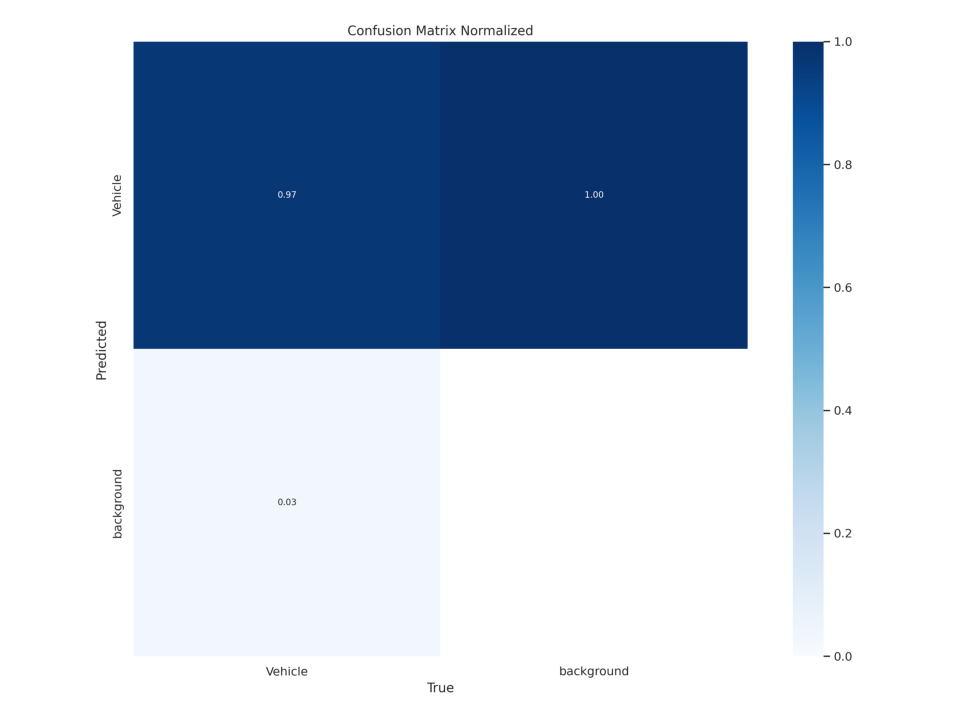

In [ ]:
# Construct the path to the normalized confusion matrix image
confusion_matrix_path = os.path.join(post_training_files_path, 'confusion_matrix_normalized.png')

# Read the image using cv2
cm_img = cv2.imread(confusion_matrix_path)

# Convert the image from BGR to RGB color space for accurate color representation with matplotlib
cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(cm_img)
plt.axis('off')
plt.show()

In [ ]:
# Construct the path to the best model weights file using os.path.join
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')

# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val')

Ultralytics YOLOv8.1.30 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25846129 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/drive/MyDrive/vehicle_detection/valid/labels.cache... 131 images, 0 backgrounds, 0 corrupt: 100%|██████████| 131/131 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 14, len(boxes) = 1251. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:14<00:00,  1.56s/it]


                   all        131       1251      0.685      0.257      0.494       0.34
         Crossover-car        131          8      0.622      0.625      0.583      0.367
                   SUV        131          3          1          0     0.0868     0.0608
             Sedan-Car        131          4          0          0     0.0627     0.0263
                 Truck        131          3      0.548       0.43      0.573      0.427
                   Van        131          5      0.737        0.6      0.673      0.368
      Van-with-trailer        131          1          1          0      0.995      0.796
Vehicle_Detection_YOLOv8 - v3 2023-12-03        131       1224      0.946      0.914      0.973      0.763
          liquid_truck        131          1          1          0          0          0
               minivan        131          1          0          0          0          0
                pickup        131          1          1          0      0.995      0.597
Spe

In [ ]:
# Convert the dictionary to a pandas DataFrame and use the keys as the index
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

# Display the DataFrame
metrics_df.round(3)

Metric Value
metrics/precision(B)         0.914
metrics/recall(B)            0.931
metrics/mAP50(B)             0.975
metrics/mAP50-95(B)          0.735
fitness                      0.759

In [ ]:
best_model.save('vehicle_detection_best_model.pt')

In [ ]:
# Define the threshold for considering traffic as heavy
heavy_traffic_threshold = 10

# Define the vertices for the quadrilaterals
vertices1 = np.array([(465, 350), (609, 350), (510, 630), (2, 630)], dtype=np.int32)
vertices2 = np.array([(678, 350), (815, 350), (1203, 630), (743, 630)], dtype=np.int32)

# Define the vertical range for the slice and lane threshold
x1, x2 = 325, 635
lane_threshold = 609

# Define the positions for the text annotations on the image
text_position_left_lane = (10, 50)
text_position_right_lane = (820, 50)
intensity_position_left_lane = (10, 100)
intensity_position_right_lane = (820, 100)

# Define font, scale, and colors for the annotations
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255, 255, 255)    # White color for text
background_color = (0, 0, 255)  # Red background for text

# Open the video
cap = cv2.VideoCapture('sample_video.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('traffic_density_analysis.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# Read until video is completed
while cap.isOpened():
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret:
        # Create a copy of the original frame to modify
        detection_frame = frame.copy()

        # Black out the regions outside the specified vertical range
        detection_frame[:x1, :] = 0  # Black out from top to x1
        detection_frame[x2:, :] = 0  # Black out from x2 to the bottom of the frame

        # Perform inference on the modified frame
        results = best_model.predict(detection_frame, imgsz=640, conf=0.4)
        processed_frame = results[0].plot(line_width=1)

        # Restore the original top and bottom parts of the frame
        processed_frame[:x1, :] = frame[:x1, :].copy()
        processed_frame[x2:, :] = frame[x2:, :].copy()

        # Draw the quadrilaterals on the processed frame
        cv2.polylines(processed_frame, [vertices1], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.polylines(processed_frame, [vertices2], isClosed=True, color=(255, 0, 0), thickness=2)

        # Retrieve the bounding boxes from the results
        bounding_boxes = results[0].boxes

        # Initialize counters for vehicles in each lane
        vehicles_in_left_lane = 0
        vehicles_in_right_lane = 0

        # Loop through each bounding box to count vehicles in each lane
        for box in bounding_boxes.xyxy:
            # Check if the vehicle is in the left lane based on the x-coordinate of the bounding box
            if box[0] < lane_threshold:
                vehicles_in_left_lane += 1
            else:
                vehicles_in_right_lane += 1

        # Determine the traffic intensity for the left lane
        traffic_intensity_left = "Heavy" if vehicles_in_left_lane > heavy_traffic_threshold else "Smooth"
        # Determine the traffic intensity for the right lane
        traffic_intensity_right = "Heavy" if vehicles_in_right_lane > heavy_traffic_threshold else "Smooth"


        # Add a background rectangle for the left lane vehicle count
        cv2.rectangle(processed_frame, (text_position_left_lane[0]-10, text_position_left_lane[1] - 25),
                      (text_position_left_lane[0] + 460, text_position_left_lane[1] + 10), background_color, -1)

        # Add the vehicle count text on top of the rectangle for the left lane
        cv2.putText(processed_frame, f'Vehicles in Left Lane: {vehicles_in_left_lane}', text_position_left_lane,
                    font, font_scale, font_color, 2, cv2.LINE_AA)

        # Add a background rectangle for the left lane traffic intensity
        cv2.rectangle(processed_frame, (intensity_position_left_lane[0]-10, intensity_position_left_lane[1] - 25),
                      (intensity_position_left_lane[0] + 460, intensity_position_left_lane[1] + 10), background_color, -1)

        # Add the traffic intensity text on top of the rectangle for the left lane
        cv2.putText(processed_frame, f'Traffic Intensity: {traffic_intensity_left}', intensity_position_left_lane,
                    font, font_scale, font_color, 2, cv2.LINE_AA)

        # Add a background rectangle for the right lane vehicle count
        cv2.rectangle(processed_frame, (text_position_right_lane[0]-10, text_position_right_lane[1] - 25),
                      (text_position_right_lane[0] + 460, text_position_right_lane[1] + 10), background_color, -1)

        # Add the vehicle count text on top of the rectangle for the right lane
        cv2.putText(processed_frame, f'Vehicles in Right Lane: {vehicles_in_right_lane}', text_position_right_lane,
                    font, font_scale, font_color, 2, cv2.LINE_AA)

        # Add a background rectangle for the right lane traffic intensity
        cv2.rectangle(processed_frame, (intensity_position_right_lane[0]-10, intensity_position_right_lane[1] - 25),
                      (intensity_position_right_lane[0] + 460, intensity_position_right_lane[1] + 10), background_color, -1)

        # Add the traffic intensity text on top of the rectangle for the right lane
        cv2.putText(processed_frame, f'Traffic Intensity: {traffic_intensity_right}', intensity_position_right_lane,
                    font, font_scale, font_color, 2, cv2.LINE_AA)

        # Write the processed frame to the output video
        out.write(processed_frame)

        # Uncomment the following 3 lines if running this code on a local machine to view the real-time processing results
        # cv2.imshow('Real-time Analysis', processed_frame)
        # if cv2.waitKey(1) & 0xFF == ord('q'):  # Press Q on keyboard to exit the loop
        #     break
    else:
        break

# Release the video capture and video write objects
cap.release()
out.release()

# Close all the frames
# cv2.destroyAllWindows()


In [ ]:
cv2.__version__

'4.8.0'